#**pH Level Forecasting - Time Series**

In [ ]:
# pip install sktime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error
# from sktime.forecasting.fbprophet import Prophet # from facebook
# from sktime.forecasting.base import ForecastingHorizon
# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.forecasting.theta import ThetaForecaster
# from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data into dataframe variable df
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pH Level Forecasting/Dataset_time.csv')
df.sample(5)

,Timestamp_Assessment,pH
127,2016-11-22 11:30:00,7.12
147,2016-12-05 10:45:00,7.30
21,2016-09-14 12:40:00,6.76
12,2016-09-10 10:40:00,6.17
29,2016-09-16 14:55:00,6.17


In [3]:
# Set Index
df.set_index('Timestamp_Assessment',inplace=True)
df.head()

,pH
Timestamp_Assessment,
2016-09-05 10:40:00,5.99
2016-09-05 14:10:00,6.03
2016-09-06 09:30:00,5.65
2016-09-07 13:40:00,6.09
2016-09-08 10:45:00,7.06


In [4]:
df.shape

(162, 1)

In [ ]:
# from scipy.stats import zscore

# # Calculate z-scores for the 'pH' column
# z_scores = zscore(df['pH'])

# threshold = 3

# # Identify outliers based on z-score
# outliers_mask = (z_scores > threshold) | (z_scores < -threshold)

# # Check if any outliers exist
# if outliers_mask.any():
#     print("Outliers detected in the 'pH' column.")
#     # Output the indices of the outliers
#     print("Indices of outliers:")
#     print(df.index[outliers_mask])

#     # Replace outliers with the median value of the column
#     median_pH = df['pH'].median()
#     df.loc[outliers_mask, 'pH'] = median_pH

#     print("Outliers treated using median value.")
# else:
#     print("No outliers detected in the 'pH' column.")


In [5]:
# #Calculate Quartiles and IQR for the 'pH' column
# Q1 = df['pH'].quantile(0.25)
# Q3 = df['pH'].quantile(0.75)
# IQR = Q3 - Q1

# # Define the threshold for outliers
# threshold = 1.5

# # Identify outliers based on IQR
# outliers_mask = (df['pH'] < Q1 - threshold * IQR) | (df['pH'] > Q3 + threshold * IQR)

# # Check if any outliers exist
# if outliers_mask.any():
#     print("Outliers detected in the 'pH' column.")
#     # Output the indices of the outliers
#     print("Indices of outliers:")
#     print(df.index[outliers_mask])

#     # Replace outliers with the median value of the column
#     median_pH = df['pH'].median()
#     df.loc[outliers_mask, 'pH'] = median_pH

#     print("Outliers treated using median value.")
# else:
#     print("No outliers detected in the 'pH' column.")


In [7]:
# Resampling the data
df.index = pd.to_datetime(df.index)
# forecast_dfs = df.resample(rule='D').median() # D=Day, M=Month, Y=Year, H=Hour, W=Week
forecast_dfs = df.resample(rule='D').mean().round(2) # D=Day, M=Month, Y=Year, H=Hour, W=Week
forecast_dfs.sample(15)

,pH
Timestamp_Assessment,
2016-10-13,NaN
2016-09-17,6.55
2016-10-02,NaN
2016-11-20,NaN
2016-09-13,5.95
2016-11-19,NaN
2016-09-14,6.32
2016-09-16,6.16
2016-12-07,7.14


In [8]:
len(forecast_dfs)

96

In [9]:
# Check for missing values
forecast_dfs.isnull().sum()

pH    36
dtype: int64

In [10]:
# Fill in Missing pH Values
forecast_df_ts = forecast_dfs.interpolate(method="linear")
forecast_df_ts['pH'] = forecast_df_ts['pH'].round(2)
forecast_df_ts.head(15)

,pH
Timestamp_Assessment,
2016-09-05,6.01
2016-09-06,5.65
2016-09-07,6.09
2016-09-08,7.04
2016-09-09,6.21
2016-09-10,6.49
2016-09-11,6.40
2016-09-12,6.31
2016-09-13,5.95


In [11]:
# Check for missing values
forecast_df_ts.isnull().sum()

pH    0
dtype: int64

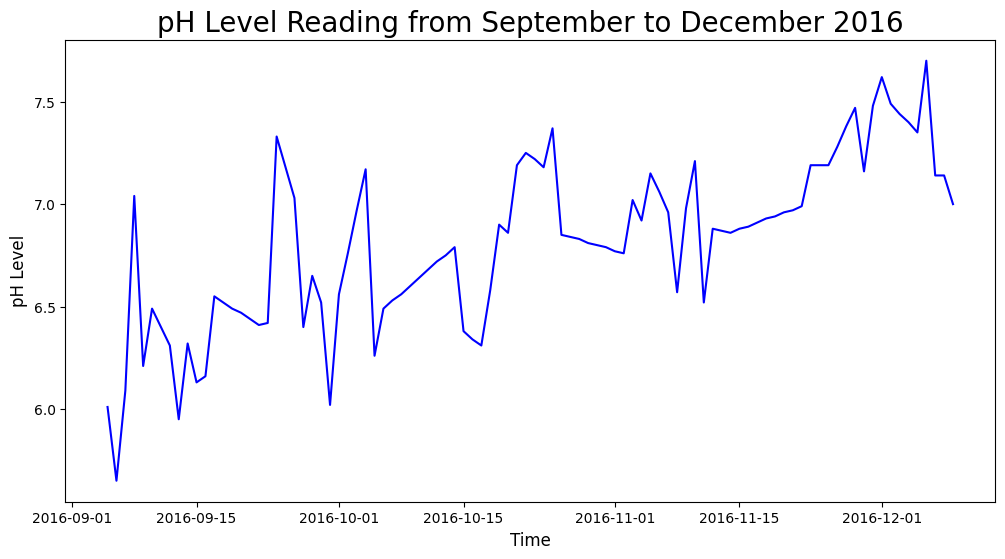

In [22]:
#Plot the pH Levels
plt.figure(figsize=(12,6))
plt.plot(forecast_df_ts, color='blue') #, marker='o')
plt.title("pH Level Reading from September to December 2016", fontsize = 20)
plt.xlabel("Time", fontsize = 12)
plt.ylabel("pH Level", fontsize = 12)
plt.show()

<Figure size 1500x1000 with 0 Axes>

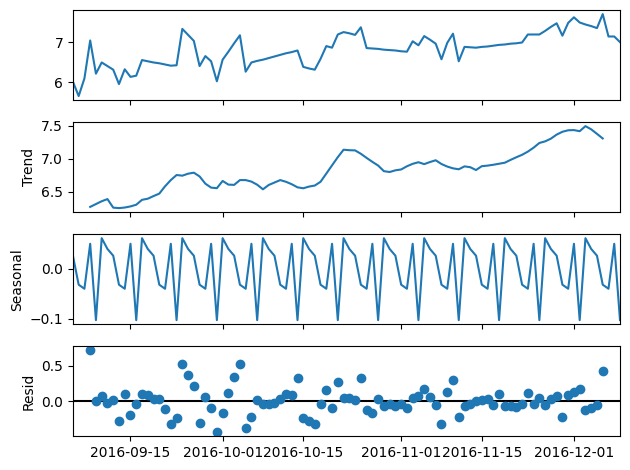

In [13]:
#Plot the Seasonal Decompopsition
plt.figure(figsize=(15,10))
decomposition = sm.tsa.seasonal_decompose(forecast_df_ts, model='additive')
fig = decomposition.plot()
plt.show()

In [14]:
# Stationary Testing
# Stationarity means that the statistical properties of a time series, such as its mean, variance,
# and autocorrelation structure, remain constant over time. Non-stationary time series often exhibit trends,
# seasonality, or other systematic patterns that change over time.

## Stationarity is often required for the AR component
## If the data is non-stationary, it can often be made stationary through techniques like differencing or transformations.
## However, there are also models designed specifically for non-stationary data, such as SARIMA (Seasonal ARIMA), which incorporates seasonal differencing.

from statsmodels.tsa.stattools import adfuller

#Ho: The data is non stationary
#H1: The data is stationary

def adfuller_test(pH):
    result = adfuller(pH)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
      print(label+' : '+str(value) )
    if result[1] > 0.05:
      print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    else:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")


In [15]:
adfuller_test(forecast_df_ts['pH'])

ADF Test Statistic : -3.9887624103245205
p-value : 0.001470511261217415
#Lags Used : 0
Number of Observations Used : 95
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [16]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00


In [17]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(forecast_df_ts['pH'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.880, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32.188, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.808, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.002, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25.535, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21.485, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30.469, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23.476, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23.476, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22.662, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.139, Time=0.09 sec
 ARIMA(2,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  -7.742
Date:                Sun, 05 May 2024   AIC                             21.485
Time:                        15:17:41   BIC                             29.146
Sample:                    09-05-2016   HQIC                            24.581
                         - 12-09-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4122      0.130      3.180      0.001       0.158       0.666
ma.L1         -0.8558      0.079    -10.780      0.000      -1.011      -0.700
sigma2         0.0685      0.007      9.994      0.000       0.055       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                25.51
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
train = forecast_df_ts.iloc[:-20]
test = forecast_df_ts.iloc[-20:]
print(train.shape, test.shape)

(76, 1) (20, 1)


In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['pH'], order=(1,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     pH   No. Observations:                   76
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.128
Date:                Sun, 05 May 2024   AIC                             26.256
Time:                        15:18:22   BIC                             33.208
Sample:                    09-05-2016   HQIC                            29.032
                         - 11-19-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4061      0.145      2.807      0.005       0.123       0.690
ma.L1         -0.8854      0.080    -11.033      0.000      -1.043      -0.728
sigma2         0.0759      0.009      8.770      0.000       0.059       0.093
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                17.72
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
start = len(train)
end = len(train) + len(test) -1
pred = model.predict(start=start, end=end, type='levels')
pred

2016-11-20    6.915566
2016-11-21    6.905644
2016-11-22    6.901615
2016-11-23    6.899979
2016-11-24    6.899315
2016-11-25    6.899045
2016-11-26    6.898936
2016-11-27    6.898891
2016-11-28    6.898873
2016-11-29    6.898866
2016-11-30    6.898863
2016-12-01    6.898862
2016-12-02    6.898861
2016-12-03    6.898861
2016-12-04    6.898861
2016-12-05    6.898861
2016-12-06    6.898861
2016-12-07    6.898861
2016-12-08    6.898861
2016-12-09    6.898861
Freq: D, Name: predicted_mean, dtype: float64

<Axes: xlabel='Timestamp_Assessment'>

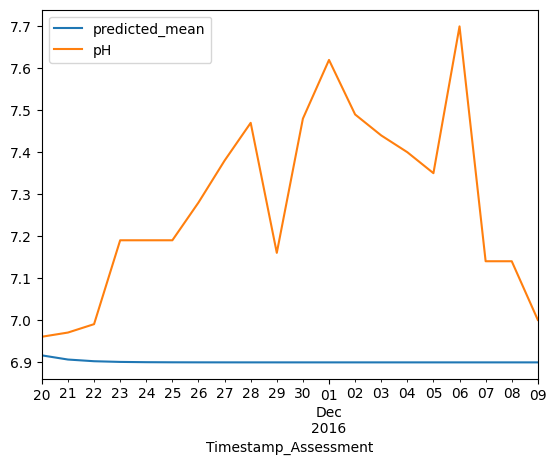

In [21]:
pred.plot(legend=True)
test['pH'].plot(legend=True)

Complex time series models, such as ARIME, SARIMA or deep learning models, may require a larger amount of data to estimate their parameters effectively. With a small dataset, these models may be prone to overfitting or underfitting, leading to suboptimal performance.

###**ARIMA**

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# def calculate_metrics(actual, predicted):
#     mae = mean_absolute_error(actual, predicted)
#     rmse = np.sqrt(mean_squared_error(actual, predicted))
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     return mae, rmse, mape

# def fit_arima_and_plot(order, data):
#     # Fit ARIMA model
#     model = ARIMA(data, order=order)
#     model_fit = model.fit()

#     # Generate predictions
#     forecast_start = 40
#     forecast_end = 96
#     forecast_df_ts['Forecast'] = model_fit.predict(start=forecast_start, end=forecast_end)

#     # Calculate metrics
#     actual = forecast_df_ts['pH'].iloc[forecast_start:forecast_end+1]  # Actual values corresponding to forecast period
#     predicted = forecast_df_ts['Forecast'].iloc[forecast_start:forecast_end+1]  # Predicted values
#     mae, rmse, mape = calculate_metrics(actual, predicted)

#     # Display model summary
#     print(f"Summary for ARIMA Order {order}:")
#     print(model_fit.summary())

#     # Output metrics
#     print("=========================================")
#     print("Metrics:")
#     print(f"MAE: {mae}")
#     print(f"RMSE: {rmse}")
#     print(f"MAPE: {mape}")
#     print("=========================================")

#     # Plot actual vs. predicted values
#     ax = forecast_df_ts[['pH', 'Forecast']].plot(figsize=(12, 5))
#     plt.title(f'ARIMA Order {order} - pH and Time Series Forecast')
#     plt.xlabel('Date')
#     plt.ylabel('pH')
#     plt.legend()
#     plt.show()

#     print("**********************************************************************************************************************************")
#     print("**********************************************************************************************************************************")
#     print("\n")

#     # Return AIC score
#     return pd.DataFrame({'order': [order], 'AIC': [model_fit.aic]})

# # Define orders to iterate over
# orders_ar = [(0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1), (0, 1, 2), (2, 1, 1), (2, 1, 2)]

# # Initialize an empty DataFrame to store AIC scores
# aic_scores_ar = pd.DataFrame(columns=['order', 'AIC'])

# # Iterate over each order
# for order in orders_ar:
#     aic_df = fit_arima_and_plot(order, forecast_df_ts['pH'])
#     aic_scores_ar = pd.concat([aic_scores_ar, aic_df], ignore_index=True)

In [ ]:
# # Find the order with the lowest AIC score
# best_order_arima = aic_scores_ar.loc[aic_scores_ar['AIC'].idxmin()]

# # Print the table with orders and AIC scores
# print("Table of AIC scores:")
# print(aic_scores_ar)

# # Print the best order based on the lowest AIC score
# print("\nBest order based on the lowest AIC score:")
# print(best_order_arima)
# print('\n')

# # Extract orders and AIC scores for plotting
# orders_plot = [str(order) for order in aic_scores_ar['order']]
# aic_scores_plot = aic_scores_ar['AIC']

# # Plot ARIMA orders against their AIC scores
# plt.bar(orders_plot, aic_scores_plot)
# plt.title('ARIMA Orders vs AIC Scores')
# plt.xlabel('ARIMA Order')
# plt.ylabel('AIC Score')
# # plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.show()


In [ ]:
# from sklearn.model_selection import train_test_split
# from statsmodels.tsa.arima.model import ARIMA
# # from sklearn.metrics import mean_absolute_error, mean_squared_error
# # import numpy as np

# def calculate_metrics(actual, predicted):
#     mae = mean_absolute_error(actual, predicted)
#     rmse = np.sqrt(mean_squared_error(actual, predicted))
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     return mae, rmse, mape

# def fit_arima_and_plot(order, train_data, test_data):
#     # Fit ARIMA model
#     model = ARIMA(train_data, order=order)
#     model_fit = model.fit()

#     # Generate predictions
#     forecast = model_fit.forecast(steps=len(test_data))

#     # Calculate metrics
#     mae, rmse, mape = calculate_metrics(test_data, forecast)

#     # Display model summary
#     print(f"Summary for ARIMA Order {order}:")
#     print(model_fit.summary())

#     # Output metrics
#     print("=========================================")
#     print("Metrics:")
#     print(f"MAE: {mae}")
#     print(f"RMSE: {rmse}")
#     print(f"MAPE: {mape}")
#     print("=========================================")

#     # Plot actual vs. predicted values
#     plt.figure(figsize=(12, 5))
#     plt.plot(train_data.index, train_data, label='Training Data')
#     plt.plot(test_data.index, test_data, label='Test Data')
#     plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')
#     plt.title(f'ARIMA Order {order} - pH and Time Series Forecast')
#     plt.xlabel('Date')
#     plt.ylabel('pH')
#     plt.legend()
#     plt.show()

#     print("**********************************************************************************************************************************")
#     print("**********************************************************************************************************************************")
#     print("\n")

# # Split data into training and test sets
# train_size = int(len(forecast_df_ts) * 0.8)  # Use 80% of data for training
# train_data, test_data = forecast_df_ts['pH'][:train_size], forecast_df_ts['pH'][train_size:]

# # Define orders to iterate over
# orders = [(0, 1, 0), (0, 1, 1), (1, 1, 1), (0, 1, 2), (2, 1, 1), (2, 1, 2)]

# # Iterate over each order
# for order in orders:
#     fit_arima_and_plot(order, train_data, test_data)


###**SARIMA**

In [ ]:
# def calculate_metrics(actual, predicted):
#     mae = mean_absolute_error(actual, predicted)
#     rmse = np.sqrt(mean_squared_error(actual, predicted))
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     return mae, rmse, mape

# def fit_sarima_and_plot(order, seasonal_order, data):
#     # Fit SARIMA model
#     model = sm.tsa.statespace.SARIMAX(data, order=order, seasonal_order=seasonal_order)
#     results = model.fit()

#     # Generate predictions
#     forecast_start = 40
#     forecast_end = 96
#     forecast_df_ts['Forecast'] = results.predict(start=forecast_start, end=forecast_end)

#     # Calculate metrics
#     actual = forecast_df_ts['pH'].iloc[forecast_start:forecast_end+1]  # Actual values corresponding to forecast period
#     predicted = forecast_df_ts['Forecast'].iloc[forecast_start:forecast_end+1]  # Predicted values
#     mae, rmse, mape = calculate_metrics(actual, predicted)

#     # Display model summary
#     print(f"Summary for SARIMA: Order {order} - Seasonal Order {seasonal_order}:")
#     print(results.summary())

#     # Output metrics
#     print("=========================================")
#     print("Metrics:")
#     print(f"MAE: {mae}")
#     print(f"RMSE: {rmse}")
#     print(f"MAPE: {mape}")
#     print("=========================================")

#     # Plot actual vs. predicted values
#     ax = forecast_df_ts[['pH', 'Forecast']].plot(figsize=(12, 5))
#     plt.title(f'SARIMA: Order {order} - Seasonal Order {seasonal_order} - pH and Time Series Forecast')
#     plt.xlabel('Date')
#     plt.ylabel('pH')
#     plt.legend()
#     plt.show()

#     print("**********************************************************************************************************************************")
#     print("**********************************************************************************************************************************")
#     print("\n")

#     # Return AIC score
#     return results.aic

# # Define orders and seasonal_orders to iterate over
# orders_sar = [(1, 1, 1)]
# seasonal_orders = [(1, 1, 1, 2), (1, 1, 1, 3), (1, 1, 1, 7)]

# # Initialize an empty DataFrame to store AIC scores
# aic_scores_sarima = pd.DataFrame(columns=['seasonal_order', 'AIC'])

# # Iterate over each combination of orders and seasonal_orders
# for order in orders_sar:
#     for seasonal_order in seasonal_orders:
#         aic = fit_sarima_and_plot(order, seasonal_order, forecast_df_ts['pH'])
#         aic_scores_sarima = pd.concat([aic_scores_sarima, pd.DataFrame({'seasonal_order': [seasonal_order], 'AIC': [aic]})], ignore_index=True)

In [ ]:
# # Find the combination with the lowest AIC score
# best_order_sarima = aic_scores_sarima.loc[aic_scores_sarima['AIC'].idxmin()]

# # Print the table with seasonal_orders and AIC scores
# print("Table of AIC scores:")
# print(aic_scores_sarima)

# # Print the best combination based on the lowest AIC score
# print("\nBest combination based on the lowest AIC score:")
# print(best_order_sarima)
# print('\n')

# # Extract seasonal orders and AIC scores for plotting
# seasonal_orders_plot = [str(row['seasonal_order']) for index, row in aic_scores_sarima.iterrows()]
# aic_scores_plot = aic_scores_sarima['AIC'].tolist()

# # Plot SARIMA orders against their AIC scores
# plt.bar(seasonal_orders_plot, aic_scores_plot)
# plt.title('SARIMA Orders vs AIC Scores')
# plt.xlabel('SARIMA Order')
# plt.ylabel('AIC Score')
# # plt.xticks(rotation=45, ha='right')
# plt.show()

###**Conclusion**

In [ ]:
# boa = best_order_arima['AIC']
# bos = best_order_sarima['AIC']

# # Plot the AIC values
# plt.bar(['ARIMA', 'SARIMA'], [boa, bos])
# plt.title('Comparison of AIC Scores')
# plt.xlabel('Model')
# plt.ylabel('AIC Score')
# plt.show()
# print('\n')

# # Determine which model performed the best
# if boa < bos:
#     print("ARIMA performed better in this scenario.")
# elif boa > bos:
#     print("SARIMA performed better in this scenario.")
# else:
#     print("Both ARIMA and SARIMA performed equally well in this scenario.")